In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
#import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

#### Get grid

In [2]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [3]:
case ='g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [4]:
variables = ['mesozooC_zint_100m_2', 'photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint','TEMP']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [5]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  mesozooC_zint_100m_2
starting on  photoC_diaz_zint
starting on  photoC_diat_zint
starting on  photoC_sp_zint
starting on  photoC_cocco_zint
starting on  TEMP


In [6]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [7]:
ds_fosi_x01["TEMP"] = ds_fosi_x01.TEMP.isel(z_t=0)

In [8]:
ds_fosi_x01["time"][688]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2015, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2015-05-16 12:00:00

### Grab May of 2015

In [9]:
ds_May2015 = ds_fosi_x01.isel(time=688)

### Trim the ds fosi to the reference period

In [10]:
ds_fosi_x01["time"][264:516]

<xarray.DataArray 'time' (time: 252)>
array([cftime.DatetimeNoLeap(1980, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2000, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1980-01-16 12:00:00 ... 2000-12-16 12:00:00

In [11]:
ds_fosi_x01 = ds_fosi_x01.isel(time=slice(264,516))

In [12]:
ds_fosi_x01.time[4]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1980, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1980-05-16 12:00:00

### reference period 1980-2000, extract mays and then make a mean of those

In [13]:
ds_fosi_x01_may = xr.Dataset()

m=4 # index for may

for year in np.arange(1980,2001,1):
    
    print(year, m)
    
    ds_tmp = ds_fosi_x01.isel(time=m).drop(['time']).compute()
    
    ds_fosi_x01_may = xr.concat([ds_fosi_x01_may, ds_tmp],'time')
    
    m = m + 12

1980 4
1981 16
1982 28
1983 40
1984 52
1985 64
1986 76
1987 88
1988 100
1989 112
1990 124
1991 136
1992 148
1993 160
1994 172
1995 184
1996 196
1997 208
1998 220
1999 232
2000 244


In [14]:
ds_fosi_x01_may = ds_fosi_x01_may.mean(dim='time')

### Total up NPP in July 2015 and reference July

In [15]:
ds_May2015['photoC_TOT_zint'] =  ds_May2015['photoC_cocco_zint'] + ds_May2015['photoC_diat_zint'] + ds_May2015['photoC_diaz_zint'] + ds_May2015['photoC_sp_zint']

In [16]:
ds_fosi_x01_may['photoC_TOT_zint'] =  ds_fosi_x01_may['photoC_cocco_zint'] + ds_fosi_x01_may['photoC_diat_zint'] + ds_fosi_x01_may['photoC_diaz_zint'] + ds_fosi_x01_may['photoC_sp_zint']

In [17]:
ds_May2015_anom = ds_May2015 - ds_fosi_x01_may

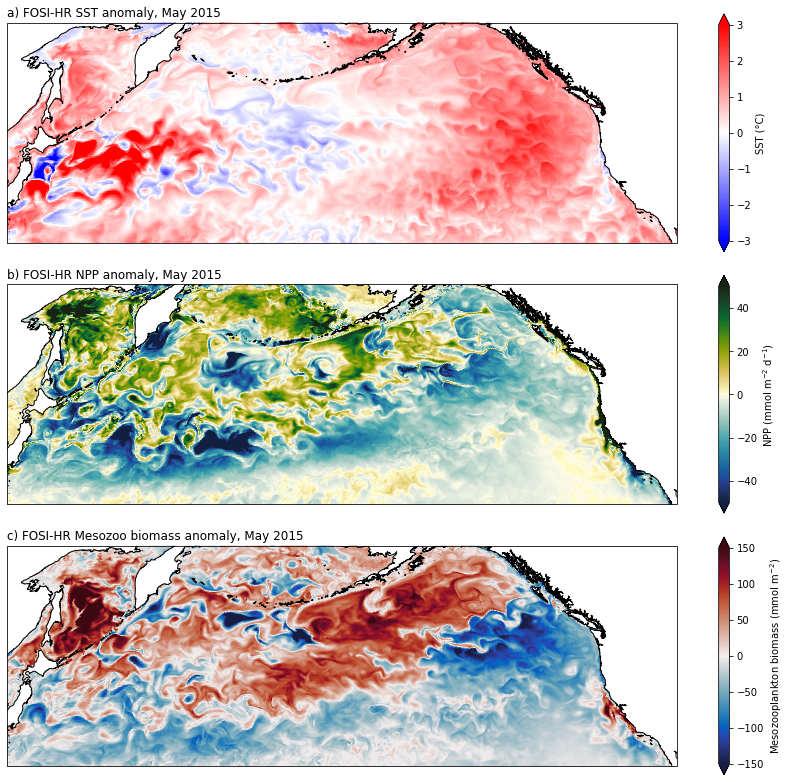

In [18]:
fig = plt.figure(figsize=(15,14))


############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('a) FOSI-HR SST anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.TEMP)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-3,vmax=3)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='SST (°C)')
                     
############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('b) FOSI-HR NPP anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.photoC_TOT_zint*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=-50,vmax=50)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('c) FOSI-HR Mesozoo biomass anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.mesozooC_zint_100m_2*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,
                   vmin=-150,vmax=150)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

#fig.savefig('/glade/work/kristenk/figs/May2015_blob.png', bbox_inches='tight', dpi=300, format='png');

### Get fish biomass for May during year 1980 to 2000 for the baseline

In [23]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/FEISTY'

### first do 1980
year = 1980
yr4="{:04d}".format(year)
file = f'{path}/FEISTY_g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001_{yr4}01-{yr4}12.nc'
ds_feisty_x01=xr.open_dataset(file)
ds_feisty_x01 =  ds_feisty_x01.isel(time=4)
ds_tmp = xr.Dataset()
ds_tmp['Pelagics'] = ds_feisty_x01.biomass.sel(group='Lp') + ds_feisty_x01.biomass.sel(group='Mp') + ds_feisty_x01.biomass.sel(group='Sp')
ds_tmp['Forages'] = ds_feisty_x01.biomass.sel(group='Mf') + ds_feisty_x01.biomass.sel(group='Sf')
ds_tmp['Demersals'] = ds_feisty_x01.biomass.sel(group='Ld') + ds_feisty_x01.biomass.sel(group='Md') + ds_feisty_x01.biomass.sel(group='Sd')
tot_fish_2d = ds_tmp['Pelagics'] + ds_tmp['Forages'] + ds_tmp['Demersals']
tot_fish_2d = tot_fish_2d.where(tot_fish_2d<1000).where(tot_fish_2d>-100)
May_avg_fish = tot_fish_2d

######### loop start here

for year in np.arange(1981,2001,1):
    print(year)
    yr4="{:04d}".format(year)
    
    file = f'{path}/FEISTY_g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001_{yr4}01-{yr4}12.nc'
            
    ds_feisty_x01=xr.open_dataset(file)

    ds_feisty_x01 =  ds_feisty_x01.isel(time=4)
    
    ds_tmp = xr.Dataset()
    
    ds_tmp['Pelagics'] = ds_feisty_x01.biomass.sel(group='Lp') + ds_feisty_x01.biomass.sel(group='Mp') + ds_feisty_x01.biomass.sel(group='Sp')
    ds_tmp['Forages'] = ds_feisty_x01.biomass.sel(group='Mf') + ds_feisty_x01.biomass.sel(group='Sf')
    ds_tmp['Demersals'] = ds_feisty_x01.biomass.sel(group='Ld') + ds_feisty_x01.biomass.sel(group='Md') + ds_feisty_x01.biomass.sel(group='Sd')
    
    tot_fish_2d = ds_tmp['Pelagics'] + ds_tmp['Forages'] + ds_tmp['Demersals']
    
    ## mask out crazy values
    tot_fish_2d = tot_fish_2d.where(tot_fish_2d<1000).where(tot_fish_2d>-100)
    
    May_avg_fish = xr.concat([May_avg_fish,tot_fish_2d], dim='time')
    
    i = i + 1
                             

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [25]:
May_avg_fish = May_avg_fish.mean(dim='time')

### Now grab 2015 fish

In [30]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/'+case+'/FEISTY/FEISTY_'+case+'_201501-201512.nc'

ds_oneyear_feisty = xr.open_dataset(path)

ds_oneyear_feisty =  ds_oneyear_feisty.isel(time=4)

ds_tmp = xr.Dataset()
    
ds_tmp['Pelagics'] = ds_oneyear_feisty.biomass.sel(group='Lp') + ds_oneyear_feisty.biomass.sel(group='Mp') + ds_oneyear_feisty.biomass.sel(group='Sp')
ds_tmp['Forages'] = ds_oneyear_feisty.biomass.sel(group='Mf') + ds_oneyear_feisty.biomass.sel(group='Sf')
ds_tmp['Demersals'] = ds_oneyear_feisty.biomass.sel(group='Ld') + ds_oneyear_feisty.biomass.sel(group='Md') + ds_oneyear_feisty.biomass.sel(group='Sd')

fish_may2015 = ds_tmp['Pelagics'] + ds_tmp['Forages'] + ds_tmp['Demersals']

fish_may2015 = fish_may2015.where(fish_may2015<1000).where(fish_may2015>-100)

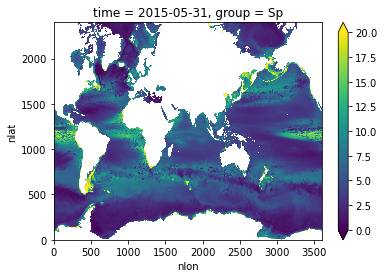

In [32]:
fish_may2015.plot(vmin=0,vmax=20)

In [33]:
Fish_anom2015 = fish_may2015 - May_avg_fish

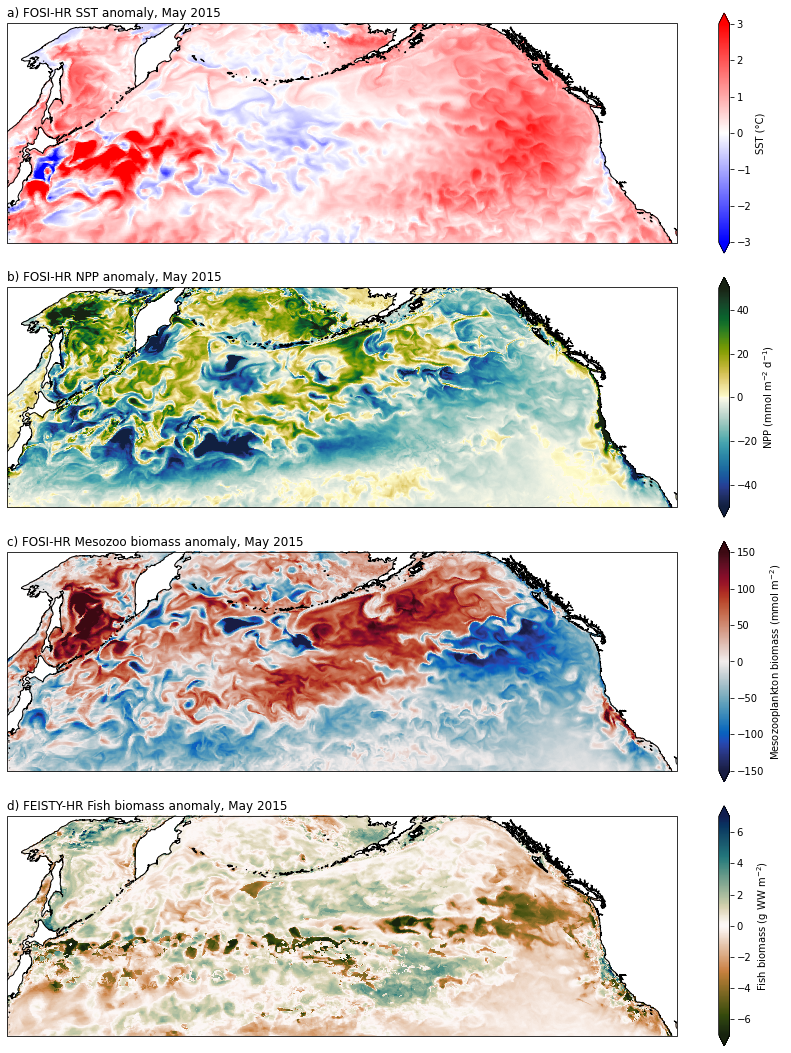

In [37]:
fig = plt.figure(figsize=(15,19))


############### 
ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('a) FOSI-HR SST anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.TEMP)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-3,vmax=3)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='SST (°C)')
                     
############### 
ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('b) FOSI-HR NPP anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.photoC_TOT_zint*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=-50,vmax=50)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('c) FOSI-HR Mesozoo biomass anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.mesozooC_zint_100m_2*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,
                   vmin=-150,vmax=150)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

############### 
ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('d) FEISTY-HR Fish biomass anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, Fish_anom2015)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                   vmin=-7,vmax=7)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Fish biomass (g WW m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)



fig.savefig('/glade/work/kristenk/figs/May2015_blob.png', bbox_inches='tight', dpi=300, format='png');